In [1]:
import matplotlib.pyplot as plt
import numpy as np
from tqdm.auto import tqdm

# 15. Coal Mining Disasters in the UK*

Adapted from [Unit 5: disastersmc.m](https://raw.githubusercontent.com/areding/6420-pymc/main/original_examples/Codes4Unit5/disastersmc.m).

The 112 data points represent the numbers of coal-mining disasters involving 10 or more men killed per year between 1851 and 1962 ({cite:t}`ukcoaldisasteroriginal`, {cite:t}`ukcoaldisasterupdate`). 

You can check out the derivation of the model we're using on the previous page, or see {cite:t}`carlinchangepoint1992` for the inspiration.

In [2]:
rng = np.random.default_rng(1)

# x is the number of coal mine disasters per year
# fmt: off
x = [4, 5, 4, 1, 0, 4, 3, 4, 0, 6, 3, 3, 4, 0, 2, 6, 3, 3, 5, 4, 5, 3, 1,
     4, 4, 1, 5, 5, 3, 4, 2, 5, 2, 2, 3, 4, 2, 1, 3, 2, 2, 1, 1, 1, 1, 3,
     0, 0, 1, 0, 1, 1, 0, 0, 3, 1, 0, 3, 2, 2, 0, 1, 1, 1, 0, 1, 0, 1, 0,
     0, 0, 2, 1, 0, 0, 0, 1, 1, 0, 2, 3, 3, 1, 1, 2, 1, 1, 1, 1, 2, 4, 2,
     0, 0, 0, 1, 4, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1]
# fmt: on

year = [y for y in range(1851, 1963)]

n = len(x)
obs = 10000
burn = 500

lambda_samples = np.zeros(obs)
mu_samples = np.zeros(obs)
m_samples = np.zeros(obs)
m_posterior_weights = np.zeros(n)

# inits
lambda_samples[0] = 4
mu_samples[0] = 0.5
m_samples[0] = 10

# hyperparameters
alpha = 4
beta = 1
gamma = 0.5
delta = 1

# sampling
for i in tqdm(range(1, obs)):
    # lambda
    current_m = int(m_samples[i - 1])
    lambda_alpha = alpha + np.sum(x[:current_m])
    lambda_beta = current_m + beta

    lambda_samples[i] = rng.gamma(lambda_alpha, 1 / lambda_beta)

    # mu
    mu_gamma = gamma + np.sum(x) - np.sum(x[:current_m])
    mu_delta = n - current_m + delta

    mu_samples[i] = rng.gamma(mu_gamma, 1 / mu_delta)

    # m
    # posterior weights
    for j in range(n):
        m_posterior_weights[j] = np.exp(
            (mu_samples[i] - lambda_samples[i]) * j
        ) * (lambda_samples[i] / mu_samples[i]) ** np.sum(x[: j + 1])
    # normalize to get probabilities
    weights = m_posterior_weights / np.sum(m_posterior_weights)

    m_samples[i] = rng.choice(range(n), replace=False, p=weights, shuffle=False)

lambda_samples = lambda_samples[burn:]
mu_samples = mu_samples[burn:]
m_samples = m_samples[burn:]

  0%|          | 0/9999 [00:00<?, ?it/s]

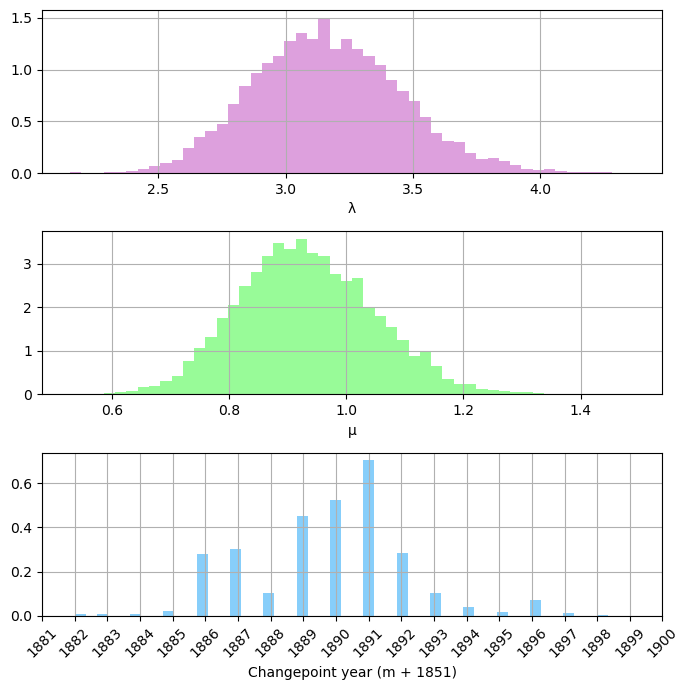

In [3]:
# posterior densities
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(7, 7))

ax1.grid(True)
ax1.hist(lambda_samples, color="plum", density=True, bins=50)
ax1.set_xlabel("λ")

ax2.grid(True)
ax2.hist(mu_samples, color="palegreen", density=True, bins=50)
ax2.set_xlabel("μ")

ax3.grid(True)
ax3.hist(m_samples + 1851, color="lightskyblue", density=True, bins=50)
ax3.set_xlabel("Changepoint year (m + 1851)")
plt.xticks(year[30:50], rotation=45)
plt.minorticks_off()

plt.tight_layout()
plt.show()

Let's check the odds ratio as well.

In [4]:
count_m_eq_n = np.sum(m_samples == n)
prob_m_equals_n = count_m_eq_n / m_samples.shape[0]
posterior_odds_ratio = prob_m_equals_n / (1 - prob_m_equals_n)

print(f"Posterior odds ratio that m=n: {posterior_odds_ratio:.4f}")

Posterior odds ratio that m=n: 0.0000


There are 0 occurrences of $m=n$ in our samples. Compared to the baseline odds of any single value from our prior, 111 to 1, this still seems pretty significant. You can see that the results cluster in the late 1880s to early 1890s, with the MAP at 1891.

In [5]:
%load_ext watermark
%watermark -n -u -v -iv

Last updated: Wed Feb 19 2025

Python implementation: CPython
Python version       : 3.12.7
IPython version      : 8.29.0

matplotlib: 3.9.2
numpy     : 1.26.4
tqdm      : 4.67.0

